# ML with SAS Viya and the SWAT Package

This demonstration shows open source integration with SAS Viya from the Python API.

# Data

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Load Packages

In [1]:
import swat
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sasctl import register_model, Session
import sasctl.pzmm as pzmm
import os
import shutil
import sys

# Get Key Variables

In [2]:
os.chdir("/".join(os.getcwd().split("\\")[:-1]))
from password import wd, hostname, port, username, password, protocol

# Connect to CAS

In [3]:
conn = swat.CAS(hostname, port, username, password, protocol=protocol)

# Load Data

In [4]:
df_cas = conn.read_csv(wd+"Data/"+"hmeq.csv", casout=dict(name="hmeq", replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(jobake).
NOTE: The table HMEQ has been created in caslib CASUSER(jobake) from binary data uploaded to Cloud Analytic Services.


In [5]:
conn.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,HMEQ,5960,13,0,utf-8,2023-06-12T15:41:27-04:00,2023-06-12T15:41:27-04:00,2023-06-12T15:41:27-04:00,UTF8,2.002218e+09,0,0,0,,,0,jobake,,2023-06-12T15:41:27-04:00,2.002218e+09


# View Data

[SWAT Functionality](https://developer.sas.com/apis/swat/python/1.0.0/api.html)

In [6]:
df_cas.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [7]:
df_cas[["BAD","LOAN","MORTDUE"]].mean()

BAD            0.199497
LOAN       18607.969799
MORTDUE    73760.817200
dtype: float64

In [8]:
df_cas.describe(include=['numeric', 'character'])

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708.0,5681.0,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,2.000000,540.000000,5053.000000,5381.000000,2.0,6.0,99.000000,11.000000,14.000000,5314.000000,16.000000,62.000000,4693.000000
top,0.000000,15000.000000,42000.000000,60000.000000,NaN,NaN,0.000000,0.000000,0.000000,206.966667,0.000000,16.000000,203.312149
freq,4771.000000,105.000000,11.000000,15.000000,3928.0,2388.0,415.000000,4527.000000,4179.000000,7.000000,2531.000000,316.000000,1.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46268.000000,66069.000000,NaN,NaN,3.000000,0.000000,0.000000,115.103197,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91491.000000,119831.500000,NaN,NaN,13.000000,0.000000,0.000000,231.574834,2.000000,26.000000,39.003141


[CAS Actions Documentation](https://go.documentation.sas.com/doc/en/pgmsascdc/v_033/allprodsactions/actionSetsByName.htm)

In [9]:
conn.loadActionSet('simple')
actions = conn.builtins.help(actionSet='simple')

NOTE: Added action set 'simple'.
NOTE: Information for action set 'simple':
NOTE:    simple
NOTE:       mdSummary - Calculates multidimensional summaries of numeric variables
NOTE:       numRows - Shows the number of rows in a Cloud Analytic Services table
NOTE:       summary - Generates descriptive statistics of numeric variables such as the sample mean, sample variance, sample size, sum of squares, and so on
NOTE:       correlation - Computes Pearson product-moment correlations.
NOTE:       regression - Performs a linear regression up to 3rd-order polynomials
NOTE:       crossTab - Performs one-way or two-way tabulations
NOTE:       distinct - Computes the distinct number of values of the variables in the variable list
NOTE:       topK - Returns the top-K and bottom-K distinct values of each variable included in the variable list based on a user-specified ranking order
NOTE:       groupBy - Builds BY groups in terms of the variable value combinations given the variables in the variab

In [10]:
conn.simple.freq(
    table = "hmeq",
    inputs = ["BAD","JOB","REASON"]
)

,Column,NumVar,CharVar,FmtVar,Level,Frequency
0,BAD,0.0,,0,1,4771.0
1,BAD,1.0,,1,2,1189.0
2,JOB,NaN,,,1,279.0
3,JOB,NaN,Mgr,Mgr,2,767.0
4,JOB,NaN,Office,Office,3,948.0
5,JOB,NaN,Other,Other,4,2388.0
6,JOB,NaN,ProfExe,ProfExe,5,1276.0
7,JOB,NaN,Sales,Sales,6,109.0
8,JOB,NaN,Self,Self,7,193.0
9,REASON,NaN,,,1,252.0


In [11]:
conn.loadActionSet('sampling')
actions = conn.builtins.help(actionSet='sampling')

NOTE: Added action set 'sampling'.
NOTE: Information for action set 'sampling':
NOTE:    sampling
NOTE:       srs -  Samples a proportion of data from the input table or partitions the data into no more than three portions
NOTE:       stratified - Samples a proportion of data or partitions the data into no more than three portions within each stratum
NOTE:       oversample - Samples a user-specified proportion of data from the event level and adjusts the ratio between rare events and non-rare events to a user-specified ratio
NOTE:       kfold - K-fold partitioning.


NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=12345 for sampling.


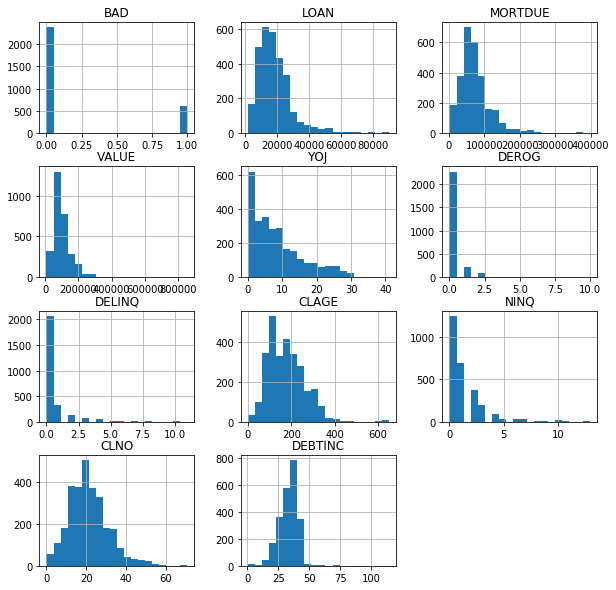

In [12]:
conn.sampling.srs(
    table   = "hmeq",
    samppct = 50,
    seed = 12345,
    partind = False,
    output  = dict(casOut = dict(name = 'mysam', replace = True),  copyVars = 'ALL')
)

mysam = conn.CASTable(name = "mysam")
df_local = mysam.to_frame()
df_local.hist(bins=20, figsize=(10,10))
plt.show()

# Cloud vs Local Data

In [13]:
type(df_cas)

swat.cas.table.CASTable

In [14]:
type(df_local)

swat.dataframe.SASDataFrame

# Impute Missing Values

In [15]:
df_cas.distinct()['Distinct'][['Column', 'NMiss']]

,Column,NMiss
0,BAD,0.0
1,LOAN,0.0
2,MORTDUE,518.0
3,VALUE,112.0
4,REASON,252.0
5,JOB,279.0
6,YOJ,515.0
7,DEROG,708.0
8,DELINQ,580.0
9,CLAGE,308.0


In [16]:
conn.dataPreprocess.impute(
    table = "hmeq",
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = list(df_cas)[1:],
    copyAllVars      = True,
    casOut           = dict(name = "hmeq", replace = True),
    code = dict(casOut = dict(name = "score_code_impute", replace = True))
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
0,LOAN,Median,IMP_LOAN,5960.0,0.0,16300.000000,
1,MORTDUE,Median,IMP_MORTDUE,5442.0,518.0,65019.000000,
2,VALUE,Median,IMP_VALUE,5848.0,112.0,89235.500000,
3,REASON,Mode,IMP_REASON,5708.0,252.0,NaN,DebtCon
4,JOB,Mode,IMP_JOB,5681.0,279.0,NaN,Other
5,YOJ,Median,IMP_YOJ,5445.0,515.0,7.000000,
6,DEROG,Median,IMP_DEROG,5252.0,708.0,0.000000,
7,DELINQ,Median,IMP_DELINQ,5380.0,580.0,0.000000,
8,CLAGE,Median,IMP_CLAGE,5652.0,308.0,173.466667,
9,NINQ,Median,IMP_NINQ,5450.0,510.0,1.000000,


In [17]:
colinfo = conn.table.columninfo(table="hmeq")['ColumnInfo']
colinfo

target = colinfo['Column'][0]

inputs = list(colinfo['Column'][1:])
nominals = list(colinfo.query('Type=="varchar"')['Column'])

inputs = [k for k in inputs if 'IMP_' in k]
nominals = [k for k in nominals if 'IMP_' in k]
nominals = [target] + nominals

display(target)
display(inputs)
display(nominals)

'BAD'

['IMP_CLAGE',
 'IMP_CLNO',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_MORTDUE',
 'IMP_NINQ',
 'IMP_VALUE',
 'IMP_YOJ',
 'IMP_JOB',
 'IMP_REASON']

['BAD', 'IMP_JOB', 'IMP_REASON']

# Partition Data

In [18]:
conn.sampling.srs(
    table   = "hmeq",
    samppct = 70,
    samppct2 = 20,
    seed = 919,
    partind = True,
    output  = dict(casOut = dict(name = "hmeq", replace = True),  copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=919 for sampling.


[SRSFreq]

 Frequencies
 
    NObs  NSamp1  NSamp2
 0  5960    4172    1192

[OutputCasTables]

             casLib  Name Label  Rows  Columns                                    casTable
 0  CASUSER(jobake)  hmeq        5960       26  CASTable('hmeq', caslib='CASUSER(jobake)')

+ Elapsed: 0.338s, user: 0.883s, sys: 0.112s, mem: 408mb

# Dimension Reduction

In [19]:
conn.loadActionSet('varReduce')
actions = conn.builtins.help(actionSet='varReduce')

NOTE: Added action set 'varReduce'.
NOTE: Information for action set 'varReduce':
NOTE:    varReduce
NOTE:       unsuper - Provides an action for performing unsupervised dimension reduction
NOTE:       super - Provides an action for performing supervised dimension reduction


In [20]:
varReduce_obj = conn.varReduce.unsuper(
    table = "hmeq",
    inputs = inputs,
    nominals = nominals[1:],
    varexp = 0.95
)

In [21]:
varReduce_inputs = list(varReduce_obj['SelectedEffects']['Variable'])
varReduce_inputs

['IMP_REASON',
 'IMP_VALUE',
 'IMP_JOB',
 'IMP_DEROG',
 'IMP_YOJ',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_CLAGE',
 'IMP_NINQ',
 'IMP_LOAN',
 'IMP_CLNO']

In [22]:
print("The variable",list(set(inputs) - set(varReduce_inputs))[0],"was removed from the input list.")

The variable IMP_MORTDUE was removed from the input list.


# Logistic Regression

In [23]:
conn.loadActionSet('regression')
actions = conn.builtins.help(actionSet='regression')

NOTE: Added action set 'regression'.
NOTE: Information for action set 'regression':
NOTE:    regression
NOTE:       glm - Fits linear regression models using the method of least squares
NOTE:       genmod - Fits generalized linear regression models
NOTE:       logistic - Fits logistic regression models
NOTE:       logisticType3 - computes Type 3 or Joint tests that all parameters for an effect are zero
NOTE:       logisticCode - writes SAS DATA step code for computing predicted values of the fitted model
NOTE:       genmodScore - creates a table on the server that contains results from scoring observations by using a fitted model
NOTE:       logisticScore - creates a table on the server that contains results from scoring observations by using a fitted model
NOTE:       glmScore - creates a table on the server that contains results from scoring observations by using a fitted model
NOTE:       logisticAssociation - computes indices of rank correlation between predicted probabilities and 

In [24]:
lr_model = conn.regression.logistic(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals[1:],
    model = dict(depvar=target, effects=varReduce_inputs, dist='binomial', link='logit'),
    store    = dict(name='lr_model',replace=True)
)

NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: 450971 bytes were written to the table "lr_model" in the caslib "CASUSER(jobake)".


In [25]:
lr_score = conn.regression.logisticScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 2'),
    restore = "lr_model",
    casout = dict(name="lr_scored", replace=True),
    copyVars = target
)

In [26]:
lr_assess = conn.percentile.assess(
   table = 'lr_scored',
   inputs = "_PRED_",
   casout = dict(name="lr_assess",replace=True),
   response = target,
   event = "1"
)

display(conn.table.fetch(table="lr_assess", to=3))
conn.table.fetch(table="lr_assess_ROC", to=3)

,_Column_,_Event_,_Depth_,_Value_,_NObs_,_NEvents_,_NEventsBest_,_Resp_,_RespBest_,_Lift_,_CumResp_,_CumRespBest_,_CumLift_,_CumLiftBest_,_PctResp_,_PctRespBest_,_CumPctResp_,_CumPctRespBest_,_Gain_,_GainBest_
0,_PRED_,1,5.0,0.658550,60.0,50.0,60.0,21.551724,25.862069,4.310345,21.551724,25.862069,4.310345,5.172414,83.333333,100.0,83.333333,100.0,3.310345,4.172414
1,_PRED_,1,10.0,0.441717,60.0,36.0,60.0,15.517241,25.862069,3.103448,37.068966,51.724138,3.706897,5.172414,60.000000,100.0,71.666667,100.0,2.706897,4.172414
2,_PRED_,1,15.0,0.336316,60.0,18.0,60.0,7.758621,25.862069,1.551724,44.827586,77.586207,2.988506,5.172414,30.000000,100.0,57.777778,100.0,1.988506,4.172414


,_Column_,_Event_,_Cutoff_,_TP_,_FP_,_FN_,_TN_,_Sensitivity_,_Specificity_,_KS_,_FPR_,_ACC_,_FDR_,_F1_,_C_,_GINI_,_GAMMA_,_TAU_,_MiscEvent_,_FNR_
0,_PRED_,1,0.00,232.0,960.0,0.0,0.0,1.000000,0.000000,0.0,1.000000,0.194631,0.805369,0.325843,0.782269,0.564538,0.57407,0.177131,0.805369,0.000000
1,_PRED_,1,0.01,230.0,952.0,2.0,8.0,0.991379,0.008333,0.0,0.991667,0.199664,0.805415,0.325318,0.782269,0.564538,0.57407,0.177131,0.800336,0.008621
2,_PRED_,1,0.02,228.0,936.0,4.0,24.0,0.982759,0.025000,0.0,0.975000,0.211409,0.804124,0.326648,0.782269,0.564538,0.57407,0.177131,0.788591,0.017241


In [27]:
lr_assess_ROC = conn.CASTable(name = "lr_assess_ROC")
lr_assess_ROC = lr_assess_ROC.to_frame()
lr_assess_ROC['Model'] = 'Logistic Regression CAS'
cutoff_index = round(lr_assess_ROC['_Cutoff_'],2)==0.5
lr_assess_ROC = lr_assess_ROC[cutoff_index].reset_index(drop=True)
lr_metrics_cas = pd.DataFrame([["Logistic Regression CAS", 1-lr_assess_ROC['_ACC_'][0], lr_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
lr_metrics_cas

,Model,Misclassification,Area Under Curve
0,Logistic Regression CAS,0.153523,0.782269


# Decision Tree

In [28]:
conn.loadActionSet('decisionTree')
actions = conn.builtins.help(actionSet='decisionTree')

NOTE: Added action set 'decisionTree'.
NOTE: Information for action set 'decisionTree':
NOTE:    decisionTree
NOTE:       dtreeTrain - Trains a decision tree
NOTE:       dtreeScore - Scores a table using a decision tree model
NOTE:       dtreeSplit - Splits decision tree nodes
NOTE:       dtreePrune - Prune a decision tree
NOTE:       dtreeMerge - Merges decision tree nodes
NOTE:       dtreeCode - Generates DATA step scoring code from a decision tree model
NOTE:       forestTrain - Trains a forest. This action requires a SAS Visual Data Mining and Machine Learning license
NOTE:       forestScore - Scores a table using a forest model
NOTE:       forestCode - Generates DATA step scoring code from a forest model
NOTE:       gbtreeTrain - Trains a gradient boosting tree. This action requires a SAS Visual Data Mining and Machine Learning license
NOTE:       gbtreeScore - Scores a table using a gradient boosting tree model
NOTE:       gbtreeCode - Generates DATA step scoring code from a grad

In [29]:
dt_model = conn.decisionTree.dtreeTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = varReduce_inputs, 
    nominals = nominals,
    casOut   = dict(name = 'dt_model', replace = True)
)

dt_score = conn.decisionTree.dtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 2'),
    model = "dt_model",
    casout = dict(name="dt_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

dt_assess = conn.percentile.assess(
   table = "dt_scored",
   inputs = "P_BAD1",
   casout = dict(name="dt_assess",replace=True),
   response = target,
   event = "1"
)

dt_assess_ROC = conn.CASTable(name = "dt_assess_ROC")
dt_assess_ROC = dt_assess_ROC.to_frame()
cutoff_index = round(dt_assess_ROC['_Cutoff_'],2)==0.5
dt_assess_ROC = dt_assess_ROC[cutoff_index].reset_index(drop=True)
dt_metrics_cas = pd.DataFrame([["Decision Tree CAS", 1-dt_assess_ROC['_ACC_'][0], dt_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
dt_metrics_cas

,Model,Misclassification,Area Under Curve
0,Decision Tree CAS,0.15604,0.673076


# Random Forest

In [30]:
rf_model = conn.decisionTree.forestTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = varReduce_inputs, 
    nominals = nominals,
    casOut   = dict(name = 'rf_model', replace = True)
)

rf_score = conn.decisionTree.forestScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 2'),
    model = "rf_model",
    casout = dict(name="rf_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

rf_assess = conn.percentile.assess(
   table = "rf_scored",
   inputs = "P_BAD1",
   casout = dict(name="rf_assess",replace=True),
   response = target,
   event = "1"
)

rf_assess_ROC = conn.CASTable(name = "rf_assess_ROC")
rf_assess_ROC = rf_assess_ROC.to_frame()
cutoff_index = round(rf_assess_ROC['_Cutoff_'],2)==0.5
rf_assess_ROC = rf_assess_ROC[cutoff_index].reset_index(drop=True)
rf_metrics_cas = pd.DataFrame([["Random Forest CAS", 1-rf_assess_ROC['_ACC_'][0], rf_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
rf_metrics_cas

,Model,Misclassification,Area Under Curve
0,Random Forest CAS,0.156879,0.75412


# Gradient Boosting

In [31]:
gb_model = conn.decisionTree.gbtreeTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = varReduce_inputs, 
    nominals = nominals,
    casOut   = dict(name = 'gb_model', replace = True)
)

gb_score = conn.decisionTree.gbtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 2'),
    model = "gb_model",
    casout = dict(name="gb_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

gb_assess = conn.percentile.assess(
   table = "gb_scored",
   inputs = "P_BAD1",
   casout = dict(name="gb_assess",replace=True),
   response = target,
   event = "1"
)

gb_assess_ROC = conn.CASTable(name = "gb_assess_ROC")
gb_assess_ROC = gb_assess_ROC.to_frame()
cutoff_index = round(gb_assess_ROC['_Cutoff_'],2)==0.5
gb_assess_ROC = gb_assess_ROC[cutoff_index].reset_index(drop=True)
gb_metrics_cas = pd.DataFrame([["Gradient Boosting CAS", 1-gb_assess_ROC['_ACC_'][0], gb_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
gb_metrics_cas

,Model,Misclassification,Area Under Curve
0,Gradient Boosting CAS,0.118289,0.911371


# Deep Learning

In [32]:
conn.loadActionSet('deepLearn')
actions = conn.builtins.help(actionSet='deepLearn')

NOTE: Added action set 'deepLearn'.
NOTE: Information for action set 'deepLearn':
NOTE:    deepLearn
NOTE:       buildModel - Creates an empty Deep Learning model
NOTE:       addLayer - Adds a layer to a Deep Learning model
NOTE:       removeLayer - Removes a layer from a Deep Learning model
NOTE:       dlPrune - Prunes a layer in a Deep Learning model
NOTE:       modelInfo - Displays model information
NOTE:       dlTune - Tunes hyperparameters for Deep Learning model
NOTE:       dlTrain - Trains a Deep Learning model
NOTE:       dlScore - Scores a table using a Deep Learning model
NOTE:       dlExportModel - Exports a Deep Learning model
NOTE:       dlLabelTarget - Assigns the target label information
NOTE:       dlImportModelWeights - Imports model weights from an external source
NOTE:       dlJoin - Joins the data table and the annotation table


In [33]:
conn.deepLearn.buildModel(
    model = dict(name='dnn',replace=True),
    type = 'dnn'
)

conn.deepLearn.addLayer(
    model = 'dnn',
    layer = dict(type='input', std='STD'),
    replace=True,
    name = 'data'
)

conn.deepLearn.addLayer(
    model = 'dnn',
    layer = dict(type='fc', n=15),
    srcLayers = 'data',
    replace=True,
    name = 'hl1'
)

conn.deepLearn.addLayer(
    model = 'dnn',
    layer = dict(type='fc', n=15),
    srcLayers = 'hl1',
    replace=True,
    name = 'hl2'
)

conn.deepLearn.addLayer(
    model = 'dnn',
    layer = dict(type='output'),
    srcLayers = 'hl2',
    replace=True,
    name = 'output'
)

conn.deepLearn.modelInfo(
    modelTable = 'dnn'
)

,Descr,Value
0,Model Name,dnn
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2


In [34]:
conn.deepLearn.dlTrain(
    table = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target = target,
    inputs = varReduce_inputs,
    nominals = nominals,
    modelTable='dnn',
    modelWeights=dict(name='dnn_trained_weights',replace=True),
    optimizer = dict(miniBatchSize=50, maxEpochs=75,  loglevel=1,
                     algorithm=dict(method='adam'))
)

conn.deepLearn.dlScore(
    table = dict(name = "hmeq", where = '_PartInd_ = 2'),
    model = 'dnn',
    initWeights = 'dnn_trained_weights',
    copyVars = target,
    casout = dict(name='dnn_scored', replace=True)
)

conn.percentile.assess(
   table = "dnn_scored",
   inputs = "_DL_P0_",
   casout = dict(name="dnn_assess",replace=True),
   response = target,
   event = "1"
)

nn_assess_ROC = conn.CASTable(name = "dnn_assess_ROC")
nn_assess_ROC = nn_assess_ROC.to_frame()
cutoff_index = round(nn_assess_ROC['_Cutoff_'],2)==0.5
nn_assess_ROC = nn_assess_ROC[cutoff_index].reset_index(drop=True)
nn_metrics_cas = pd.DataFrame([["Neural Network CAS", 1-nn_assess_ROC['_ACC_'][0], nn_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
nn_metrics_cas

NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 542.
NOTE:  The approximate memory cost is 2.00 MB.
NOTE:  The total number of workers is 3.
NOTE:  The total number of threads on each worker is 48.
NOTE:  The maximum mini-batch size per thread on each worker is 50.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 7200.
NOTE:  The optimization reached the maximum number of epochs.
NOTE:  The total time is       3.08 (s).


,Model,Misclassification,Area Under Curve
0,Neural Network CAS,0.135906,0.842852


# Hyperparameter Tuning

In [35]:
all_models_cas = pd.concat([lr_metrics_cas, dt_metrics_cas, rf_metrics_cas, gb_metrics_cas, nn_metrics_cas])
all_models_cas.sort_values('Misclassification').reset_index(drop=True)

,Model,Misclassification,Area Under Curve
0,Gradient Boosting CAS,0.118289,0.911371
1,Neural Network CAS,0.135906,0.842852
2,Logistic Regression CAS,0.153523,0.782269
3,Decision Tree CAS,0.156040,0.673076
4,Random Forest CAS,0.156879,0.754120


In [36]:
conn.loadActionSet('autotune')
actions = conn.builtins.help(actionSet='autotune')

NOTE: Added action set 'autotune'.
NOTE: Information for action set 'autotune':
NOTE:    autotune
NOTE:       tuneSvm - Automatically adjusts support vector machine parameters to tune a model for minimum error
NOTE:       tuneForest - Automatically adjusts forest parameters to tune a model for minimum error
NOTE:       tuneDecisionTree - Automatically adjusts decision tree parameters to tune a model for minimum error
NOTE:       tuneNeuralNet - Automatically adjusts neural network parameters to tune a model for minimum error
NOTE:       tuneGradientBoostTree - Automatically adjusts gradient boosting tree parameters to tune a model for minimum error
NOTE:       tuneFactMac - Automatically adjusts factorization machine parameters to tune a model for minimum error
NOTE:       tuneBnet - Automatically adjusts Bayesian network classifier parameters to tune a model for minimum error
NOTE:       tuneTsne - Automatically adjusts t-Distributed Stochastic Neighbor Embedding algorithm parameters 

In [37]:
gb_tune_model = conn.autotune.tuneGradientBoostTree(
    trainOptions = dict(
        table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
        target   = target, 
        inputs   = varReduce_inputs, 
        nominals = nominals,
        savestate = dict(name='gb_tune_astore', replace=True),
        casOut   = dict(name = 'gb_tune_model', replace = True) ) ,
    tunerOptions = dict(seed = 802, maxEvals = 10, maxTime = 60, searchmethod='GA', objective="MCE")
)

gb_tune_model["BestConfiguration"]

NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=10.
NOTE: Autotune option MAXTIME=60 (sec.).
NOTE: Autotune option SEED=802.
NOTE: Autotune objective is 'Misclassification'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Autotune number of parallel evaluations is set to 3, each using 1 worker nodes.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             0.2014          0.89
                 1          10             0.1135          4.45
NOTE: Data was partitioned during tuning, to tune based on validation score; the final model is trained and scored on all data.
NOTE: 4670814 bytes were written to the table "gb_tune_astore" in the caslib "CASUSER(jobake)".
NOTE: The number of trees used in the final model is 92.
NOTE: Autotune time 

,Parameter,Name,Value
0,Evaluation,Evaluation,5
1,Number of Variables to Try,M,8
2,Learning Rate,LEARNINGRATE,0.34
3,Sampling Rate,SUBSAMPLERATE,0.5
4,Lasso,LASSO,1.11111111
5,Ridge,RIDGE,1.11111111
6,Number of Bins,NBINS,91
7,Maximum Tree Levels,MAXLEVEL,7
8,Misclassification,Objective,0.1135091926


In [38]:
gb_tune_score = conn.decisionTree.gbtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 2'),
    model = "gb_tune_model",
    casout = dict(name="gb_tune_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

gb_tune_assess = conn.percentile.assess(
   table = "gb_tune_scored",
   inputs = "P_BAD1",
   casout = dict(name="gb_tune_assess",replace=True),
   response = target,
   event = "1"
)

gb_tune_assess_ROC = conn.CASTable(name = "gb_tune_assess_ROC")
gb_tune_assess_ROC = gb_tune_assess_ROC.to_frame()
cutoff_index = round(gb_tune_assess_ROC['_Cutoff_'],2)==0.5
gb_tune_assess_ROC = gb_tune_assess_ROC[cutoff_index].reset_index(drop=True)
gb_tune_metrics_cas = pd.DataFrame([["Tuned Gradient Boosting CAS", 1-gb_tune_assess_ROC['_ACC_'][0], gb_tune_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
all_models_cas = pd.concat([all_models_cas, gb_tune_metrics_cas])
all_models_cas.sort_values('Misclassification').reset_index(drop=True)

,Model,Misclassification,Area Under Curve
0,Tuned Gradient Boosting CAS,0.081376,0.937691
1,Gradient Boosting CAS,0.118289,0.911371
2,Neural Network CAS,0.135906,0.842852
3,Logistic Regression CAS,0.153523,0.782269
4,Decision Tree CAS,0.156040,0.673076
5,Random Forest CAS,0.156879,0.754120


# Model Interpretability

In [39]:
conn.loadActionSet('explainModel')
actions = conn.builtins.help(actionSet='explainModel')

NOTE: Added action set 'explainModel'.
NOTE: Information for action set 'explainModel':
NOTE:    explainModel
NOTE:       linearExplainer - Uses linear models to explain already trained models. Supports global linear surrogates as well as the local methods: LIME and KERNEL SHAP.
NOTE:       partialDependence - Computes the partial dependence of an already trained model.
NOTE:       shapleyExplainer - Computes Shapley value estimates for a query given a reference table


In [40]:
pd_obj = conn.explainmodel.partialdependence(
    table = "hmeq",
    modelTable = "gb_tune_astore",
    inputs = varReduce_inputs,
    nominals = nominals[1:],
    predictedTarget = "P_BAD1",
    analysisVariable = dict(name="IMP_DEBTINC", nbins=50),
    outputTables     = dict(names="PartialDependence", replace=True),
)

pd_obj["PartialDependence"].head()

NOTE: Starting the partialDependence action.
NOTE: Generating replicates.
NOTE: Finished generating replicates.
NOTE: The size of the replicates dataset is approximately 5.4656 MB. To reduce the size of the dataset, decrease the value of the NBINS, MAXLEVELS, or SAMPLESIZE parameter.
NOTE: The CAS table 'PartialDependence' in caslib 'CASUSER(jobake)' has 50 rows and 4 columns.


,Bin,IMP_DEBTINC,MeanPrediction,StdErr
0,1,0.524499,0.101511,0.007193
1,2,4.663023,0.101511,0.007193
2,3,8.801546,0.101511,0.007193
3,4,12.940070,0.101511,0.007193
4,5,17.078593,0.090113,0.006884


C:\Users\jobake\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jobake\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jobake\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


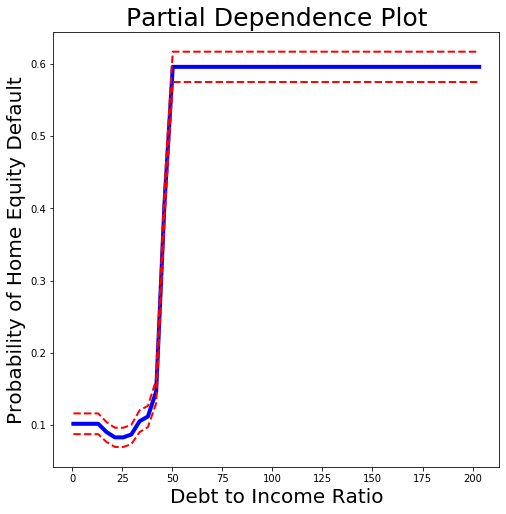

In [41]:
pd_table = conn.CASTable(name="PartialDependence")
pd_table = pd_table.to_frame()
pd_table["lb"] = pd_table["MeanPrediction"] - 2*pd_table["StdErr"]
pd_table["ub"] = pd_table["MeanPrediction"] + 2*pd_table["StdErr"]

plt.figure(figsize=(8,8))
plt.plot( 'IMP_DEBTINC', 'MeanPrediction', data=pd_table, color='blue', linewidth=4)
plt.plot( 'IMP_DEBTINC', 'lb', data=pd_table, color='red', linewidth=2, linestyle='dashed')
plt.plot( 'IMP_DEBTINC', 'ub', data=pd_table, color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Debt to Income Ratio', fontsize=20)
plt.ylabel('Probability of Home Equity Default', fontsize=20)
plt.title('Partial Dependence Plot', fontsize=25)
plt.show()

# Score All Partitions

In [42]:
gb_tune_score = conn.decisionTree.gbtreeScore(
    table    = "hmeq",
    model = "gb_tune_model",
    casout = dict(name="gb_tune_scored",replace=True),
    copyVars = [target,"_PartInd_"],
    encodename = True,
    assessonerow = True
)

conn.dataStep.runCode(code='''
    data train_obs_preds (keep = BAD P_BAD1) valid_obs_preds (keep = BAD P_BAD1) test_obs_preds (keep = BAD P_BAD1);
        set gb_tune_scored;
        if _partind_ = 1 then output train_obs_preds;
        else if _partind_ = 2 then output valid_obs_preds;
        else output test_obs_preds;
    run;
'''
)

df_train_obs_preds = pd.DataFrame(conn.CASTable(name="train_obs_preds").to_frame())
df_valid_obs_preds = pd.DataFrame(conn.CASTable(name="valid_obs_preds").to_frame())
df_test_obs_preds = pd.DataFrame(conn.CASTable(name="test_obs_preds").to_frame())

# Create Metadata Directory

In [43]:
output_dir = os.getcwd()+"\\Model_Manager\\Metadata"
model_name = "Python_CAS_GB_Tune_Pipeline_DSSC"
data_name = "HMEQ"
zip_folder = output_dir +"\\"+ data_name +"_"+ model_name

In [44]:
if os.path.exists(zip_folder):
    shutil.rmtree(zip_folder)

os.makedirs(zip_folder)

# Save Imputation DATA Step Score Code

In [45]:
conn.dataStep.runCode(code='''
    data score_code_impute (keep = DataStepSrc);
        set score_code_impute;
    run;
'''
)

score_code_impute = conn.CASTable(name = "score_code_impute")
score_code_impute = score_code_impute.to_frame()
np.savetxt(zip_folder+"\\score_code_impute.txt", score_code_impute.values, fmt="%s")
score_code_impute[:100]

,DataStepSrc
0,_ngbys_ = 1;\n _igby_ = 0;\n _tnn_ntran...


# Save Model DATA Step Score Code

In [46]:
conn.decisionTree.gbtreeCode(
    modelTable = "gb_tune_model",
    code = dict(casOut = dict(name = "score_code_model", replace = True))
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(jobake),score_code_model,1,10,"CASTable('score_code_model', caslib='CASUSER(j..."


In [47]:
conn.dataStep.runCode(code='''
    data score_code_model (keep = DataStepSrc);
        set score_code_model;
    run;
'''
)

score_code_model = conn.CASTable(name = "score_code_model")
score_code_model = score_code_model.to_frame()
np.savetxt(zip_folder+"\\score_code_model.txt", score_code_model.values, fmt="%s")
score_code_model[:100]

,DataStepSrc
0,length _strfmt_499625599_ $7; drop _strfmt_...


# Save Pipeline DATA Step Score Code

In [48]:
score_code = score_code_impute["DataStepSrc"][0] + "\n\n\n\n\n\n\n\n\n\n" + score_code_model["DataStepSrc"][0]
score_code = pd.DataFrame([score_code], columns=["DataStepSrc"])
np.savetxt(zip_folder+"\\score_code.txt", score_code.values, fmt="%s")

# Register Model

In [49]:
# sess = Session(hostname, username, password)

In [50]:
model_name = "Python_CAS_GB_Tune_Pipeline_DSSC"
project = "MM_OS_Test"
metric_labels = ['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION']
output_data = pd.DataFrame(columns=metric_labels, data=[[0.5, 'A']])
target_event_level = 1

model_info = dict(
    name = model_name,
    description = "A CAS Model with DATA Step Score Code",
    scoreCodeType = "DATA step",
    algorithm = "Gradient Boosting",
    modeler = "jobake",
    tool = "CAS",
    function = "Classification",
    targetVariable = target,
    targetLevel = "Binary",
    classificationEventProbabilityVariableName = "P_BAD1",
    classificationTargetEventValue = 1,
    trainTable = "hmeq"
)

In [51]:
pzmm.JSONFiles().writeVarJSON(inputData = df_local[list(df_local)[1:]], 
                              isInput = True, 
                              jPath = zip_folder)

pzmm.JSONFiles().writeVarJSON(inputData = output_data, 
                              isInput = False, 
                              jPath = zip_folder)

inputVar.json was successfully written and saved to C:\Users\jobake\FSBU\Model_Manager\Metadata\HMEQ_Python_CAS_GB_Tune_Pipeline_DSSC\inputVar.json
outputVar.json was successfully written and saved to C:\Users\jobake\FSBU\Model_Manager\Metadata\HMEQ_Python_CAS_GB_Tune_Pipeline_DSSC\outputVar.json


In [52]:
pzmm.JSONFiles().calculateFitStat(trainData = df_train_obs_preds, 
                                  validateData = df_valid_obs_preds, 
                                  testData = df_test_obs_preds, 
                                  jPath = zip_folder)

pzmm.JSONFiles().generateROCLiftStat(targetName = target, 
                                     targetValue = target_event_level, 
                                     swatConn = conn, 
                                     trainData = df_train_obs_preds, 
                                     validateData = df_valid_obs_preds, 
                                     testData = df_test_obs_preds, 
                                     jPath = zip_folder)

dmcas_fitstat.json was successfully written and saved to C:\Users\jobake\FSBU\Model_Manager\Metadata\HMEQ_Python_CAS_GB_Tune_Pipeline_DSSC\dmcas_fitstat.json
NOTE: Added action set 'percentile'.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib CASUSER(jobake).
NOTE: The table SCOREDVALUES has been created in caslib CASUSER(jobake) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib CASUSER(jobake).
NOTE: The table SCOREDVALUES has been created in caslib CASUSER(jobake) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib CASUSER(jobake).
NOTE: The table SCOREDVALUES has been created in caslib CASUSER(jobake) from binary data uploaded to Cloud Analytic Services.
dmcas_roc.json was successfully written and saved to C:\Users\jobake\FSBU\Model_Manager\Met

In [53]:
files = [
    dict(name="Score code", file=open(zip_folder+"/score_code.txt"), role='Score code'),
    dict(name="Inputs", file=open(zip_folder+"/inputVar.json"), role='Input variables'),
    dict(name="Outputs", file=open(zip_folder+"/outputVar.json"), role='Output variables'),
    dict(name="Fitstat", file=open(zip_folder+"/dmcas_fitstat.json"), role='Properties and Metadata'),
    dict(name="ROC", file=open(zip_folder+"/dmcas_roc.json"), role='Properties and Metadata'),
    dict(name="Lift", file=open(zip_folder+"/dmcas_lift.json"), role='Properties and Metadata')
]

In [54]:
# model = register_model(model_info, name=model_name, project=project, files=files, force=False)

# End Session

In [55]:
conn.session.endSession()

+ Elapsed: 0.00489s, user: 0.000395s, sys: 0.0081s, mem: 1.02mb